### Assess Novelty in the Control Dataset

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from distance import *
from mi_density import *
from utils import *

from pymatgen.core import Structure

import textalloc as ta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 10
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=[
        "#348ABD",
        "#A60628",
        "#7A68A6",
        "#467821",
    ]
)

colors = [
    '#348abd',  # Start color
    '#4c7dc1',
    '#696ebd',
    '#865baf',
    '#9c4497',
    '#aa2a76',
    '#ae0d50',
    '#a60628'   # End color
]
n_bins = 256
cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

import warnings
warnings.filterwarnings("ignore")

/Users/andrewf/miniconda3/envs/DISCOVERII_clone/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load formulas and structures from dataset folder.

In [2]:
MAT_DB = "control_dataset"

# get all cif files in folder
files = [file for file in os.listdir(MAT_DB) if ".cif" in file]

structures = []
formulas = []
for filename in files:
    structure = Structure.from_file(os.path.join(MAT_DB, filename))
    structures.append(structure)
    formulas.append(str(structure.formula))

data = pd.DataFrame({"formula": formulas, "structure": structures, "filename": files})

### Load the distance matrices.

Optionally, you can re-generate them from the data.

In [3]:
use_precomputed = True

if use_precomputed:
    lostop_dm = np.load("precomputed/control_lostop_dm.npy")
    elmd_dm = np.load("precomputed/control_elmd_dm.npy")
else:
    lostop_dm = get_lostop_dm(data["structure"].values)
    np.save("precomputed/control_lostop_dm.npy", lostop_dm)

    elmd_dm = get_elmd_dm(data["formula"].values)
    np.save("precomputed/control_elmd_dm.npy", elmd_dm)

### Compute material densities using MI decay profile.

In [4]:
df = pd.DataFrame()
mi_data = {}

for dm, name in zip([lostop_dm, elmd_dm], ["lostop", "elmd"]):

    cutoff, mi_profile = get_MI_profile(dm, n_thresholds=1000)

    mi_data[name] = [cutoff, mi_profile]

    print(f"MI cutoff for {name}: {cutoff}")

    df[f'{name}_density'] = compute_mi_density(dm, cutoff, mi_profile)

df['formula'] = data['formula']

MI cutoff for lostop: 2.3856733965742234
MI cutoff for elmd: 13.986305666666668


### Plot MI Profiles for LoStOP and ElMD

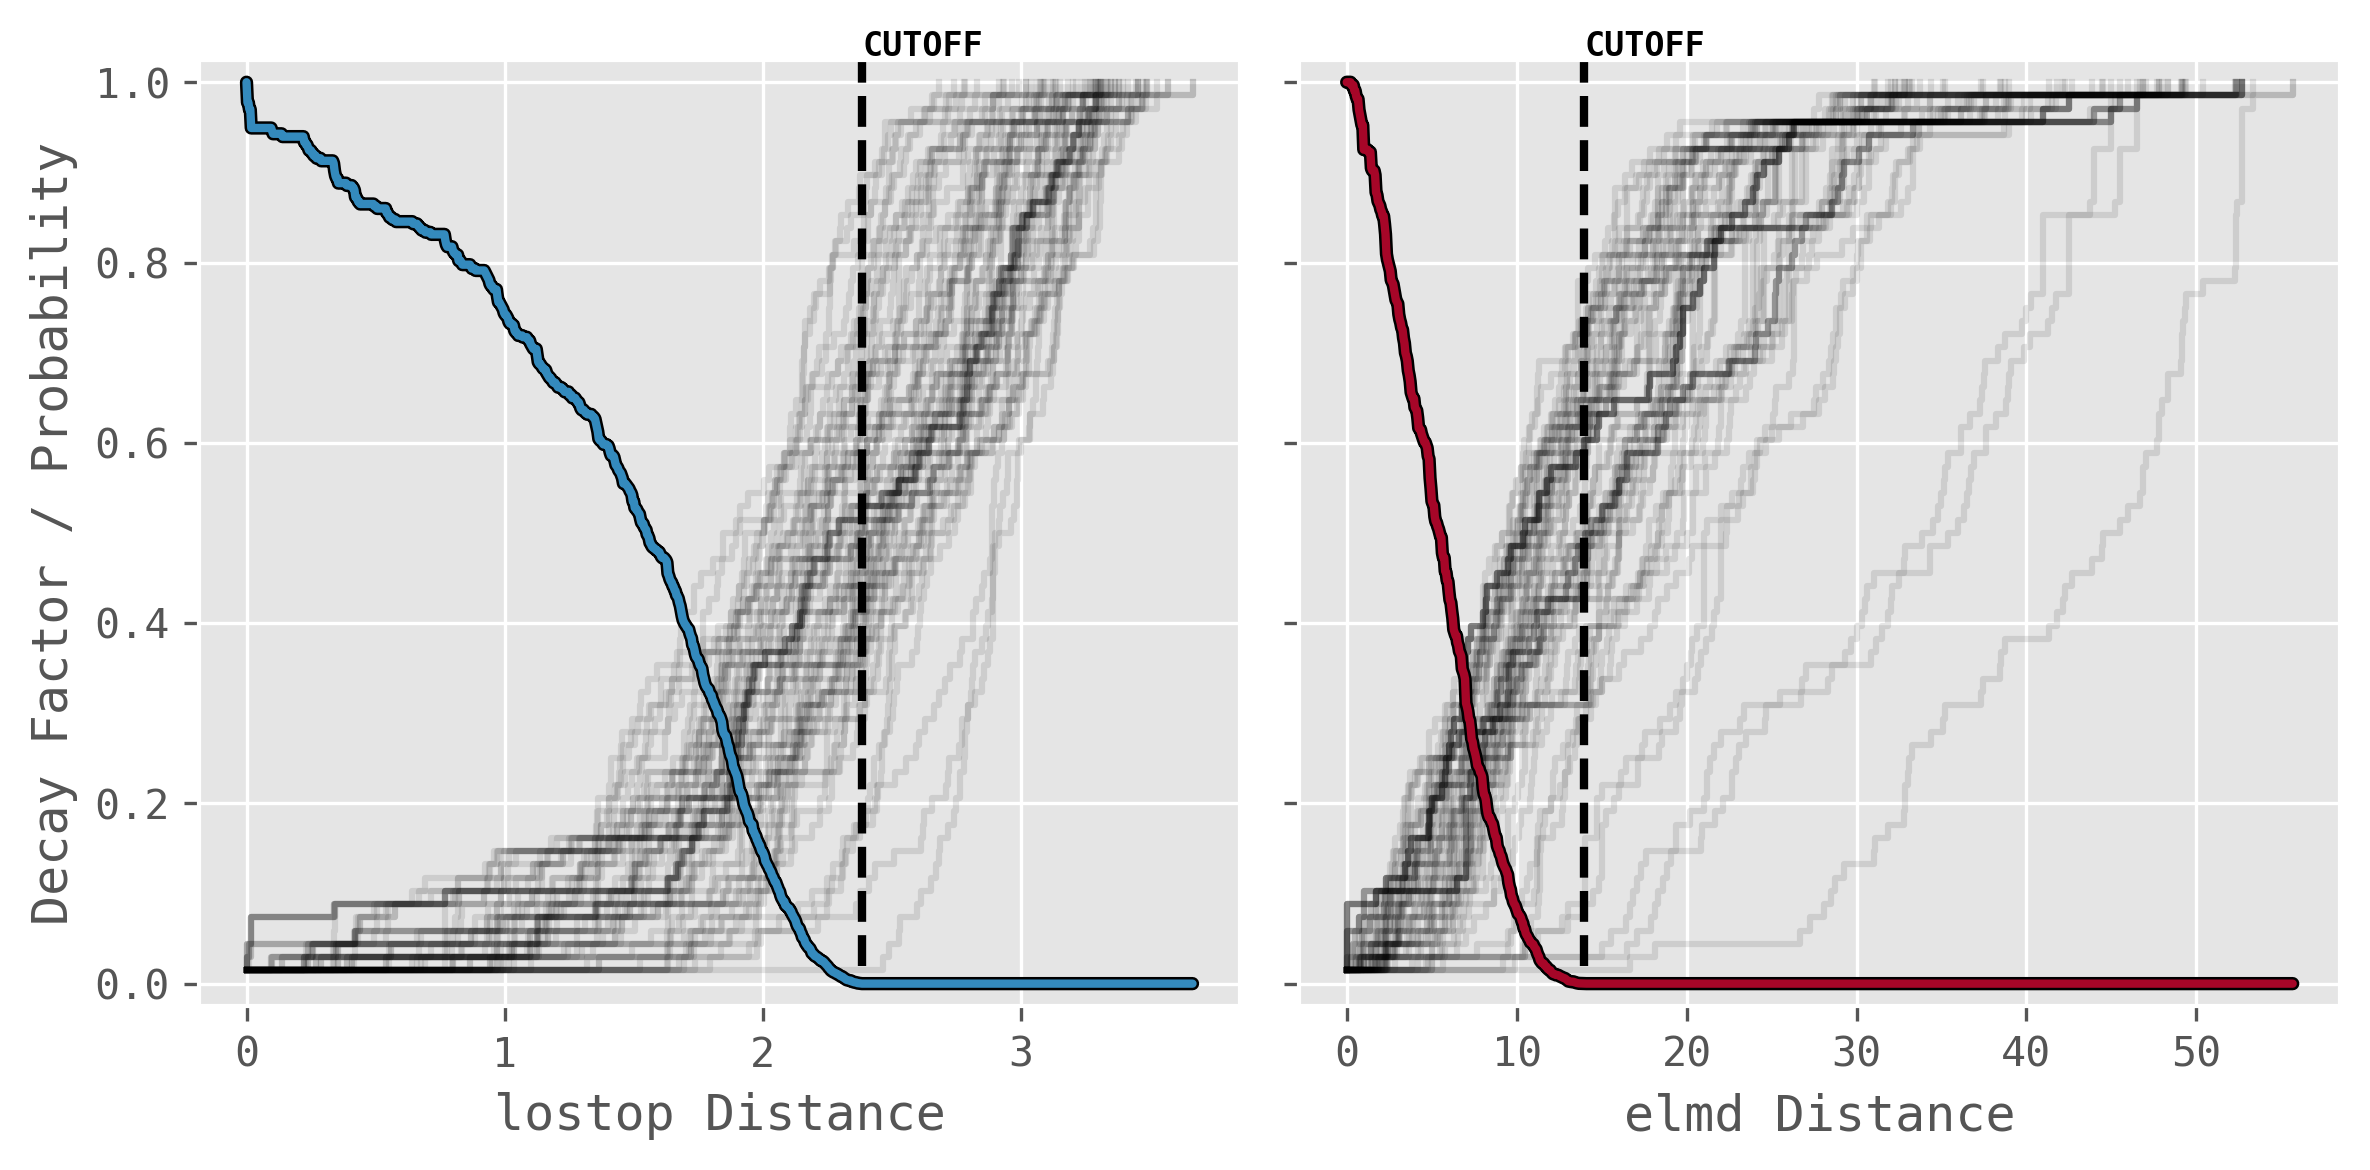

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4), layout="tight", dpi=300, sharey=True)

for i, (dm, name) in enumerate(zip([lostop_dm, elmd_dm], ["lostop", "elmd"])):

    cutoff, mi_profile = get_MI_profile(dm, n_thresholds=1000)

    # now plot the cumulative dist
    for row in dm:
        count = np.ones(row.shape[0])
        cs = np.cumsum(count)/np.sum(count)
        ax[i].step(np.sort(row), cs, color='k', alpha=0.1,  where='post')

    x = np.linspace(0, np.max(dm), len(mi_profile))
    mi_profile[x > cutoff] = 1
    ax[i].plot(x, (1-mi_profile)/np.max(1-mi_profile), lw=3.2, color='k', solid_capstyle='round')
    ax[i].plot(x, (1-mi_profile)/np.max(1-mi_profile), lw=2, color=f'C{i}', solid_capstyle='round')

    ax[i].vlines(cutoff, ymin=0.02, ymax=1.025, color=f'k', linestyle='--', lw=2)

    ax[i].text(
        x=cutoff,
        y=1.04,
        s="CUTOFF",
        color="k",
        fontsize=8,
        ha="left",
        va="center",
        weight="bold",
    )

    ax[i].set_xlabel(f"{name} Distance")

ax[0].set_ylabel('Decay Factor / Probability')
ax[0].set_ylim(-0.025, 1.025)

plt.show()

### Plot the cumulative distribution for SiC Polymorphs and As3Pb5ClO12

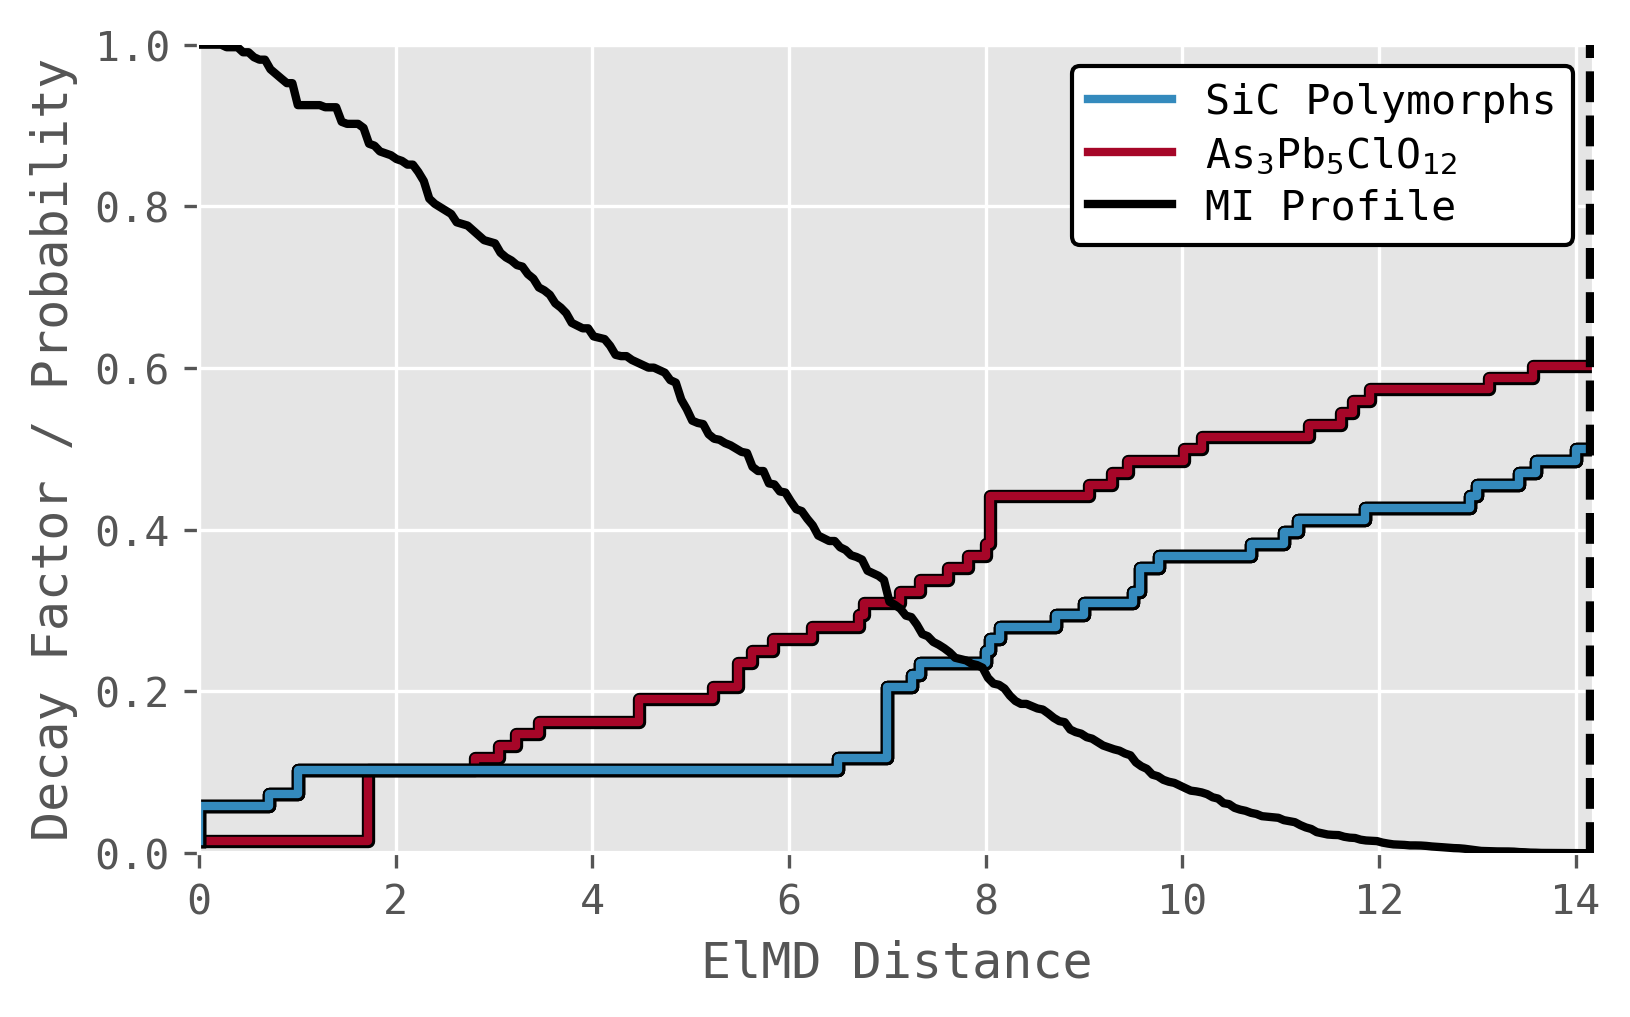

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5), dpi=300)

x = np.linspace(0, np.max(elmd_dm), 1000)

for i, row in enumerate(elmd_dm):
    count = np.ones(row.shape[0])
    cs = np.cumsum(count)/np.sum(count)
    if i in [46, 49, 54, 58]: # SiC indices
        ax.step(np.sort(row), cs, color='k', alpha=1, lw=3.2, where='post')
        ax.step(np.sort(row), cs, color='C0', alpha=1, lw=2, where='post')
    elif i in [9]: # As3Pb5ClO12 index
        ax.step(np.sort(row), cs, color='k', alpha=1, lw=3.2, where='post')
        ax.step(np.sort(row), cs, color='C1', alpha=1, lw=2, where='post')
    else:
        continue


cutoff = mi_data['elmd'][0]
profile = mi_data['elmd'][1]
profile[x > cutoff] = 1

plt.plot(x, (1-profile)/np.max(1-profile), color='k', lw=2, zorder=11)

plt.plot([], [], color='C0', lw=2, label='SiC Polymorphs')
plt.plot([], [], color='C1', lw=2, label='As$_3$Pb$_5$ClO$_{12}$')
plt.plot([], [], color='k', lw=2, label='MI Profile')

plt.axvline(14.143, color='k', zorder=11, lw=2, ls='--')
legend = ax.legend(facecolor='white', framealpha=1, edgecolor='k', loc='upper right', labelspacing=0.3)
legend.legendPatch.set_linewidth(1)

plt.xlim(0,14.19) 
plt.ylim(0,1.0)

plt.ylabel('Decay Factor / Probability')
plt.xlabel('ElMD Distance')

plt.show()

### Plot the cumulative distributions of the SiO2 Polymorphs

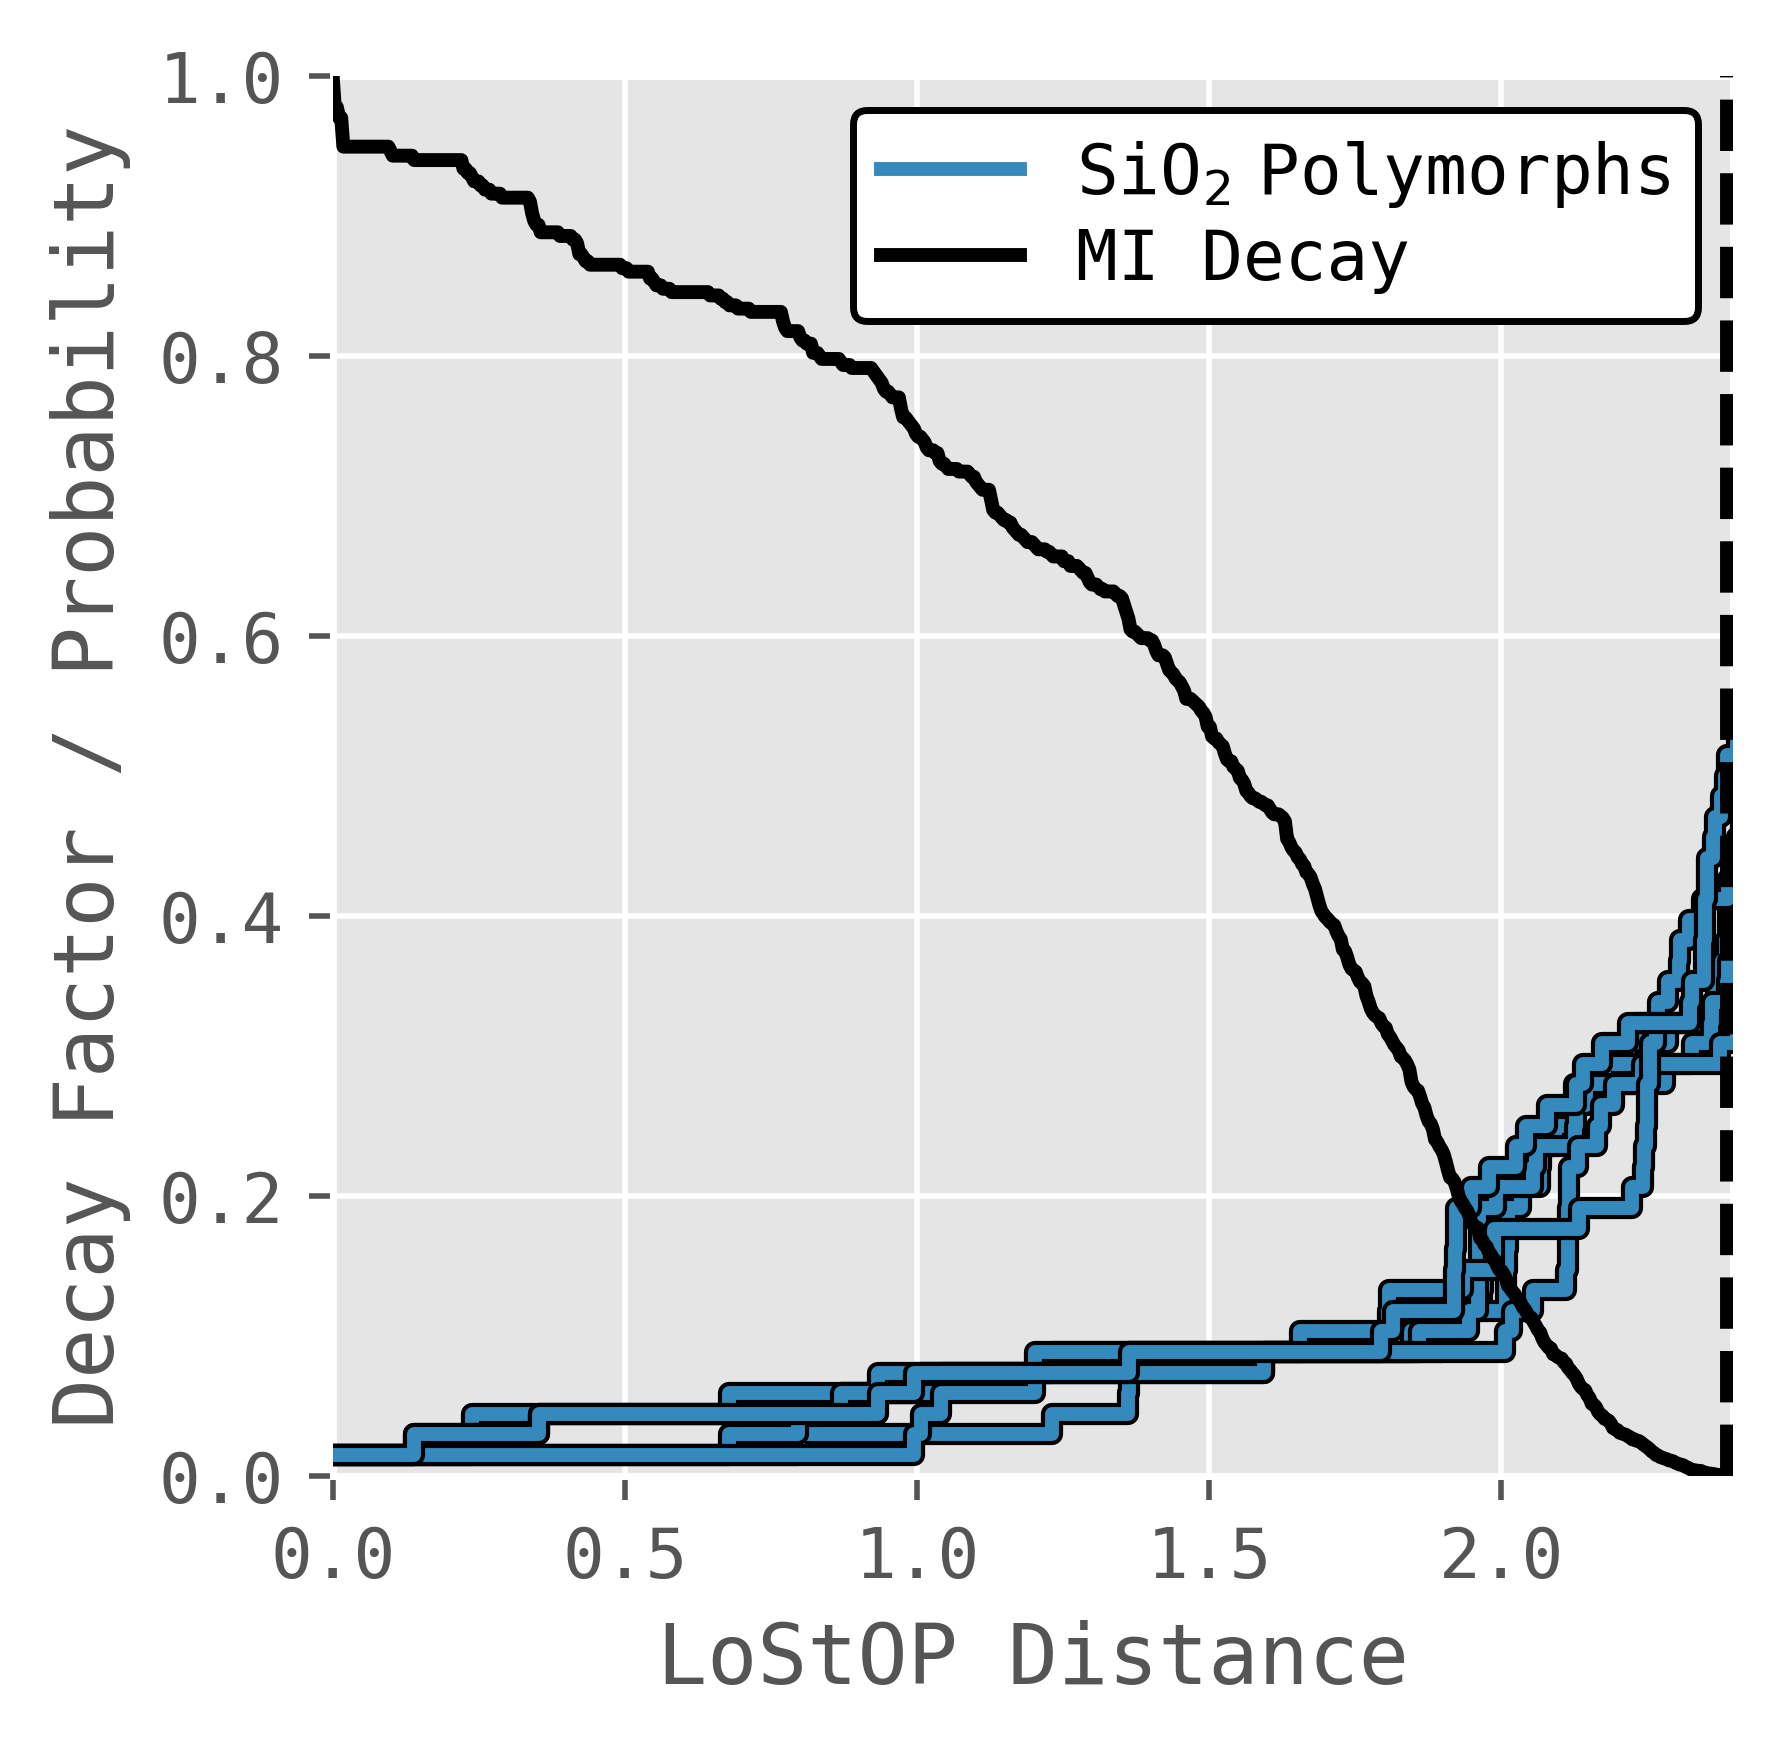

In [7]:

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), dpi=500)
POS = [0.17, 0.17, 0.8, 0.8]
ax.set_position(POS, which="both")


x = np.linspace(0, np.max(lostop_dm), 1000)

for i, row in enumerate(lostop_dm):
    count = np.ones(row.shape[0])
    cs = np.cumsum(count)/np.sum(count)
    if i in [52, 50, 64, 1, 3, 55]: # SiO2 indices
        ax.step(np.sort(row), cs, color='k', alpha=1, lw=3.2,  where='post', zorder=10)
        ax.step(np.sort(row), cs, color='C0', alpha=1, lw=2,  where='post', zorder=10)
    else:
        continue

cutoff = mi_data['lostop'][0]
profile = mi_data['lostop'][1]
profile[x > cutoff] = 1

plt.plot(x, (1-profile)/np.max(1-profile), color='k', lw=2, zorder=11)

# create dummy lines for legend
plt.plot([], [], color='C0', lw=2, label='SiO$_2\,\,$Polymorphs')
# plt.plot([], [], color='C0', lw=2, label='SiC Polymorphs')
# plt.plot([], [], color='C1', lw=2, label='As$_3$Pb$_5$ClO$_{12}$')
plt.plot([], [], color='k', lw=2, label='MI Decay')

plt.axvline(cutoff, color='k', zorder=11, lw=2, ls='--')
legend = ax.legend(facecolor='white', framealpha=1, edgecolor='k', loc='upper right',  labelspacing=0.25)
legend.legendPatch.set_linewidth(1)
plt.xlim(0,cutoff+0.01) 
plt.ylim(0,1.0)


plt.ylabel('Decay Factor / Probability')
plt.xlabel('LoStOP Distance')

plt.show()

### Plot the structural distances of the SiO2 Polymorphs

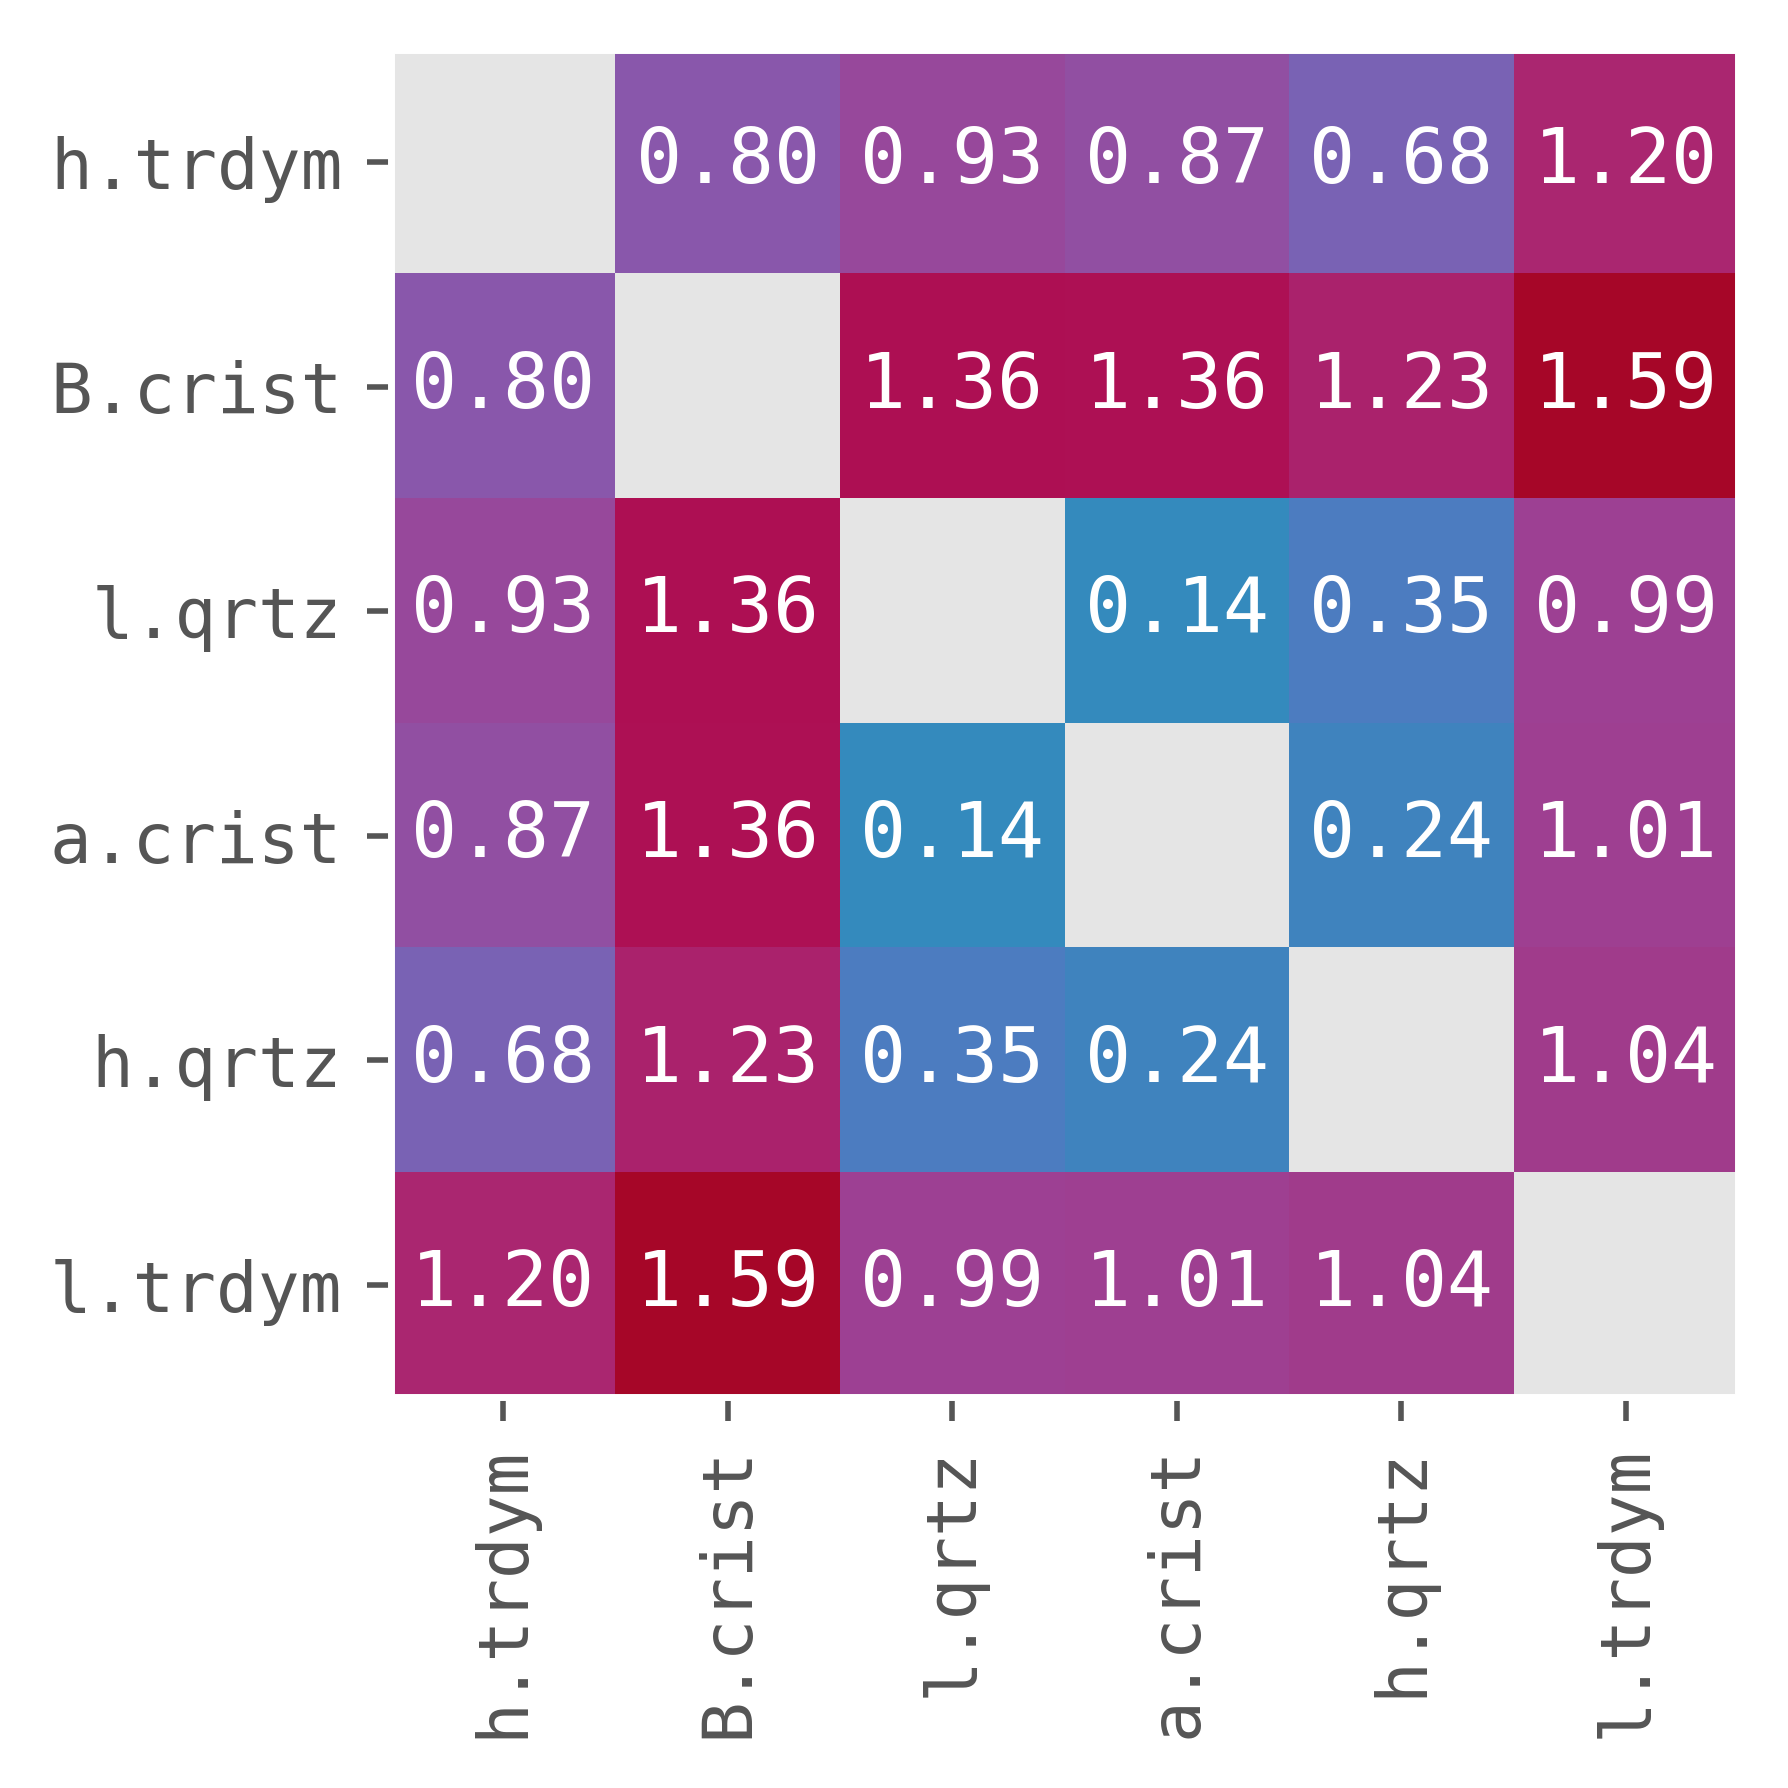

In [8]:
dummy_dm = lostop_dm[[52, 50, 64, 1, 3, 55]][:, [52, 50, 64, 1, 3, 55]]

dummy_dm = np.where(dummy_dm == 0, np.nan, dummy_dm)

mask = np.triu(np.ones_like(dummy_dm))

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), dpi=500)

plt.imshow(dummy_dm, cmap=cmap)

# Labels remain the same
labels = data['filename'].values[[52, 50, 64, 1, 3, 55]]
labels = [label.split('[')[1].split(']')[0] for label in labels]

plt.xticks(range(6), labels, rotation=90)
plt.yticks(range(6), labels, rotation=0)

# Only annotate lower triangle
for i in range(6):
    for j in range(6):
        # if i > j:  # Only lower triangle
        if True:  # Only lower triangle
            plt.text(j, i, f'{dummy_dm[i,j]:.2f}', 
                    ha='center', va='center', 
                    fontsize=11,
                    color='#E5E5E5' if np.isnan(dummy_dm[i,j]) else 'w')

plt.grid(False)
plt.show()

### Plot material densities along chemical and structural axes.

Note that the publication figure was adjusted post-hoc for visual clarity due to positioning issues with the `textalloc` library.

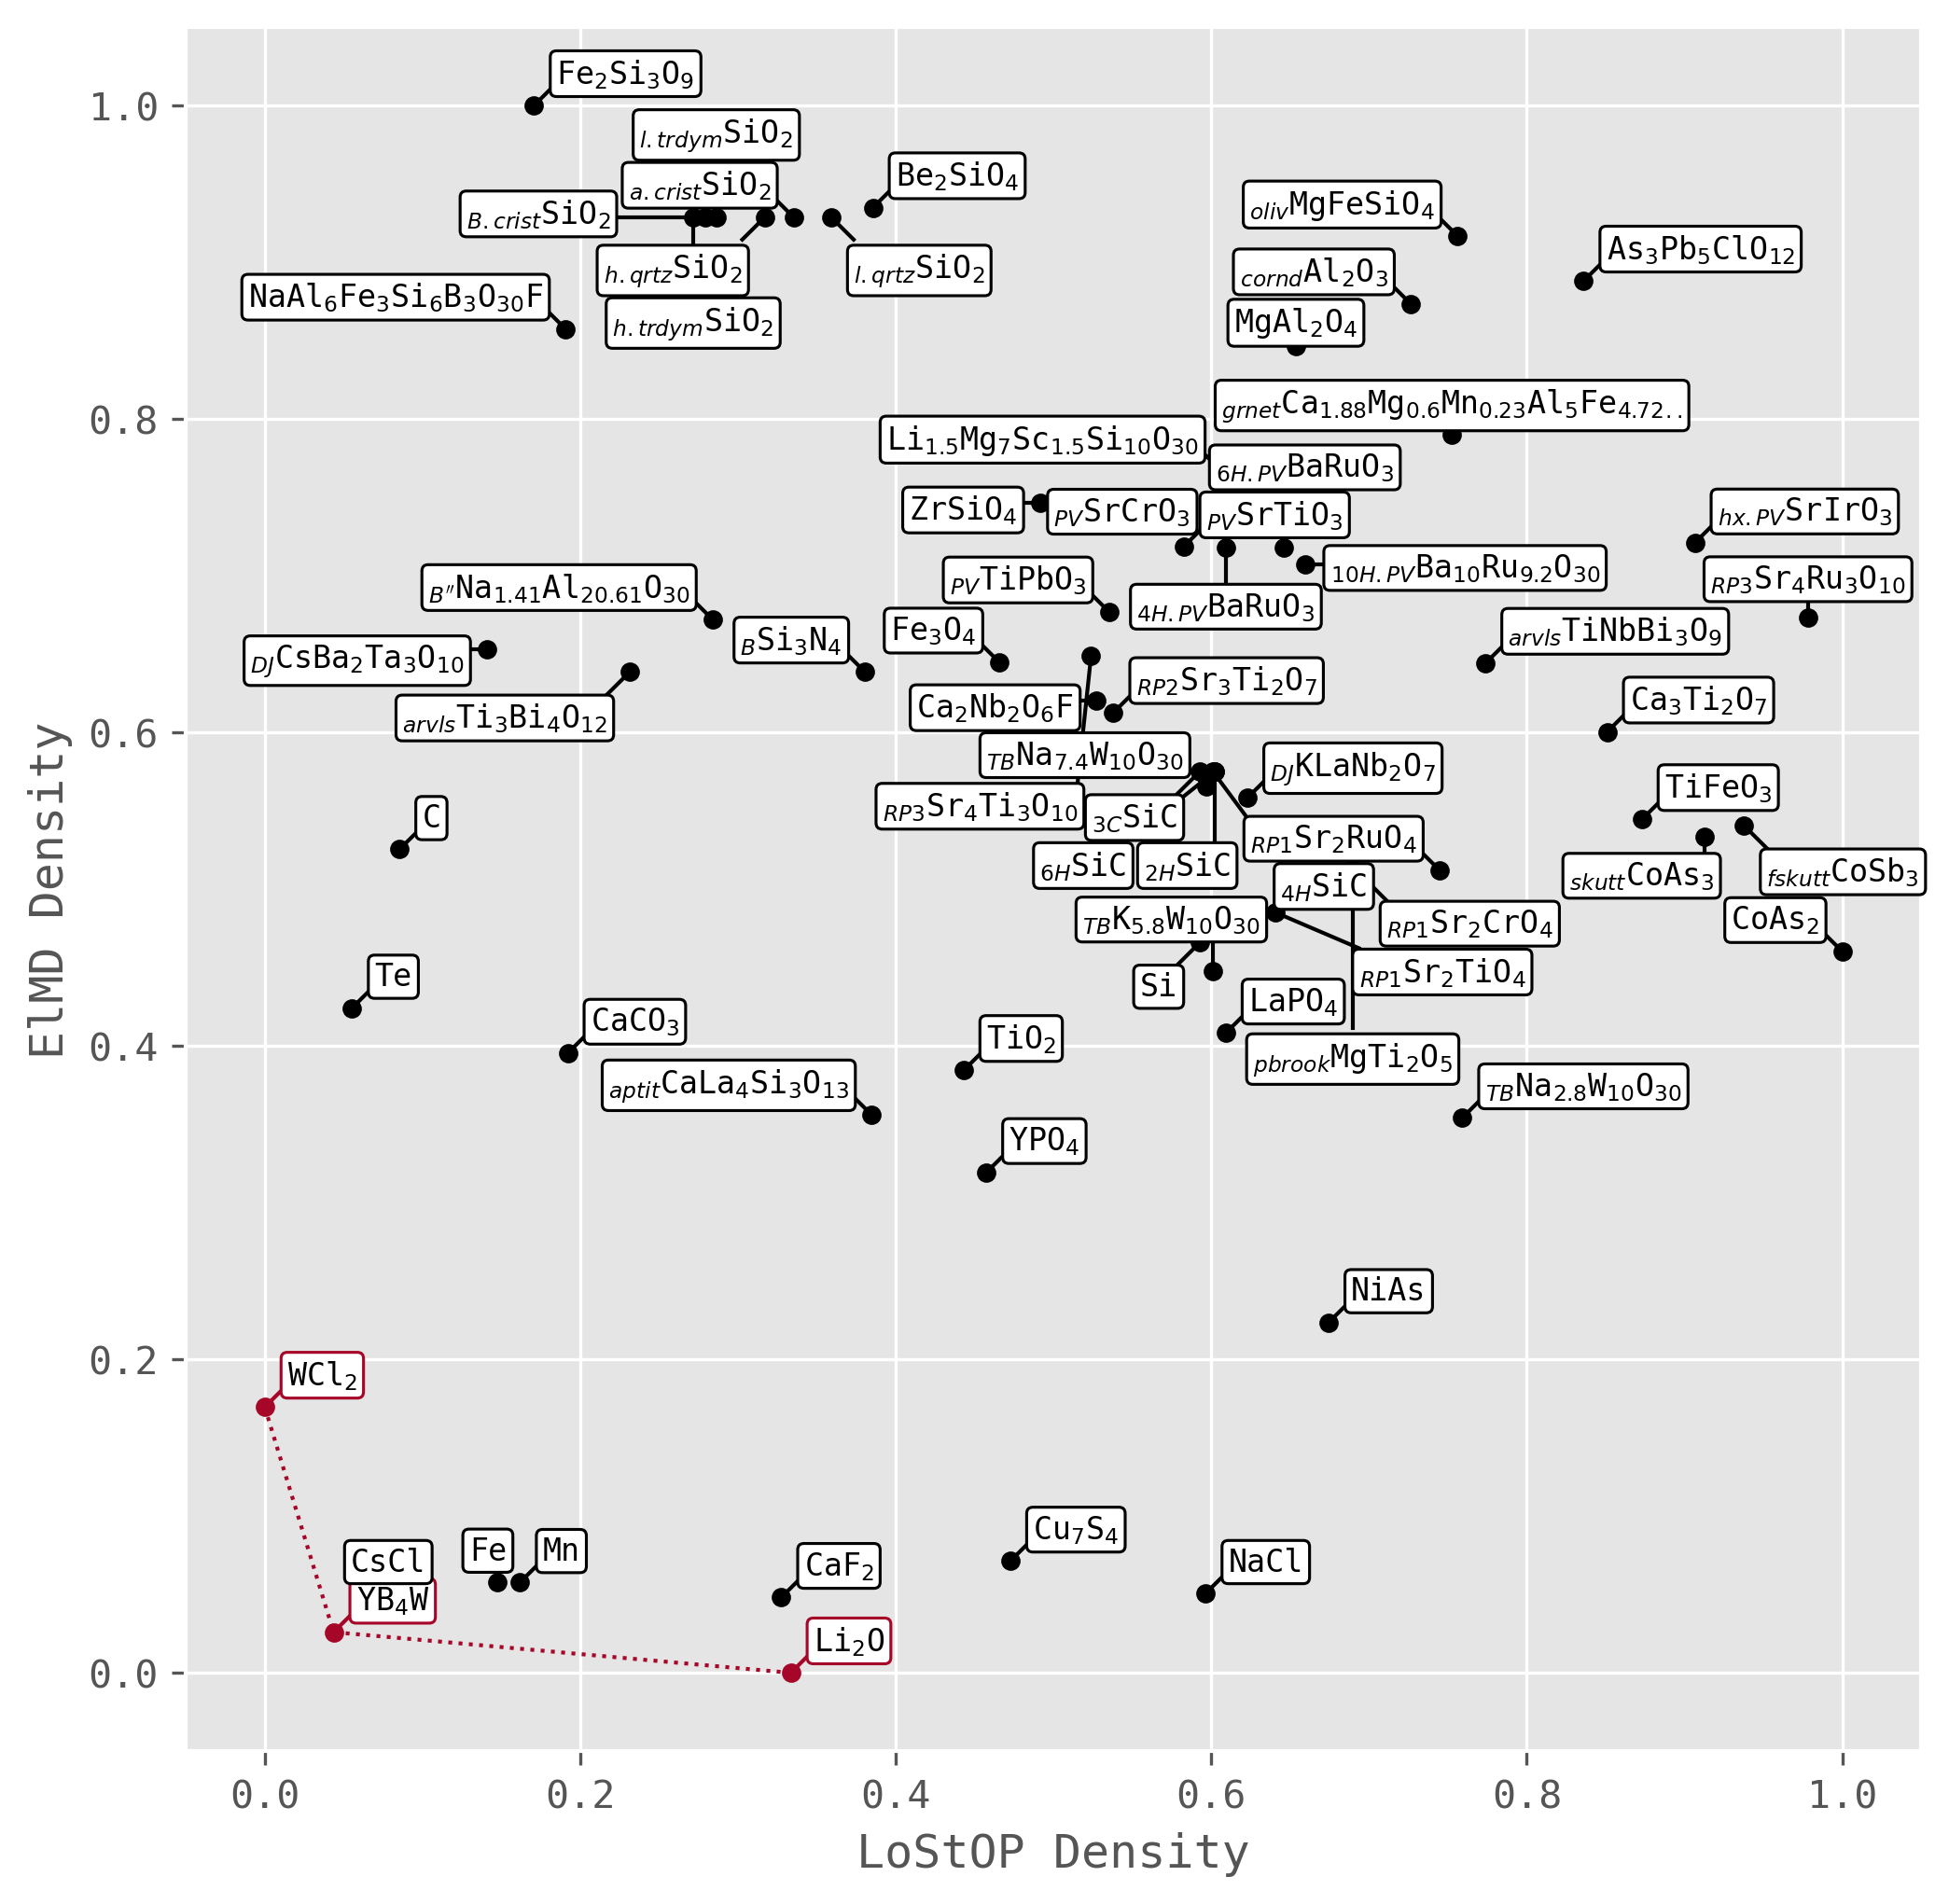

In [9]:
scaled_df = df.copy()

# scale the scaled_df
scaled_df[['lostop_density', 'elmd_density']] = MinMaxScaler().fit_transform(scaled_df[['lostop_density', 'elmd_density']])

# get some nice formula labels
labels = [reduce_single_formula(formula) for formula in scaled_df['formula'].values]
for i, label in enumerate(labels):
    if "[" in data['filename'].values[i]:
        labels[i] = "$_{" + data['filename'].values[i].split(']')[0].split('[')[1] + "}$" + str(label)

fig, ax = plt.subplots(figsize=(8, 8), dpi=300)

# find the pareto optimal points and plot the front
p_idx = is_pareto_efficient(scaled_df[['lostop_density', 'elmd_density']].values, return_mask=False)
pareto_labels = [labels[i] for i in p_idx]
pareto_x = scaled_df['lostop_density'].loc[p_idx]
pareto_y = scaled_df['elmd_density'].loc[p_idx]
pareto_x, pareto_y = zip(*sorted(zip(pareto_x, pareto_y), key=lambda pair: pair[1]))
ax.plot(pareto_x, pareto_y, color='C1', lw=1, ls=':', marker='None')

# plot points with custom colors for pareto points
for i in range(len(scaled_df)):
    ax.scatter(
        scaled_df['lostop_density'].iloc[i],
        scaled_df['elmd_density'].iloc[i],
        color='C1' if i in p_idx else 'k',
        s=20,
        zorder=10,
    )

# label pareto points
ta.allocate(ax,
            x=scaled_df['lostop_density'].loc[p_idx],
            y=scaled_df['elmd_density'].loc[p_idx],
            text_list=pareto_labels,
            x_scatter=scaled_df['lostop_density'].loc[p_idx].values,
            y_scatter=scaled_df['elmd_density'].loc[p_idx].values,
            x_lines=[pareto_x],
            y_lines=[pareto_y],
            textsize=8,
            nbr_candidates=10000,
            linecolor='C1',
            avoid_crossing_label_lines=True,
            avoid_label_lines_overlap=True,
            bbox=dict(boxstyle="round", fc="w", ec="C1", pad=0.2, lw=0.75),
            zorder=15,
            )

# drop p_idx indices from scaled_df and labels
scaled_df = scaled_df.drop(scaled_df.index[p_idx])
labels = [label for i, label in enumerate(labels) if i not in p_idx]

ta.allocate(ax,
            x=scaled_df['lostop_density'],
            y=scaled_df['elmd_density'],
            text_list=labels,
            x_scatter=scaled_df['lostop_density'].values,
            y_scatter=scaled_df['elmd_density'].values,
            x_lines=[pareto_x],
            y_lines=[pareto_y],
            textsize=8,
            nbr_candidates=10000,
            linecolor='k',
            avoid_crossing_label_lines=True,
            avoid_label_lines_overlap=True,
            bbox=dict(boxstyle="round", fc="w", ec="k", pad=0.2, lw=0.75),
            zorder=15,
            )

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

# Set labels
ax.set_xlabel("LoStOP Density")
ax.set_ylabel("ElMD Density")
plt.show()